# Mortos no massacre de Gaza - 2023-2024
## Preparação de dado auxiliar - Pirâmide etária

Esse notebook faz parte do tutorial sobre as mortes de palestinos no ataque de Israel a Gaza após o ataque do Hamas
em 7 de outubro de 2023.

Neste notebook, realizamos a limpeza de um dado auxiliar para a análise: a pirâmide etária de Gaza, isto é,
a distribuição da população por sexo e idade. A pirâmide utilizada foi extraída do 
[CIA World Factbook](https://pt.wikipedia.org/wiki/The_World_Factbook), o livro 
de fatos sobre o mundo da CIA, disponível aqui: <https://www.cia.gov/the-world-factbook/countries/gaza-strip/> 

A análise principal deste tutorial está no notebook: [10_ajuste-modelo_MCMC_mortos-gaza.ipynb](10_ajuste-modelo_MCMC_mortos-gaza.ipynb)

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import sys

sys.path.append("../80_material-complementar/")
import auxiliar.graficos as ag

## Obtenção dos dados

No [site da CIA](https://www.cia.gov/the-world-factbook/countries/gaza-strip/), encontramos apenas o seguinte gráfico:

![alt text](imagens/piramide_etaria_cia-factbook_2023.jpeg "Gráfico da pirâmide etária de Gaza, em 2023, segundo a CIA")

Para extrair os dados desse gráfico, utilizamos a ferramenta online [Web Plot Digitizer](https://apps.automeris.io/wpd/). Os dados extraídos serão tratados na seção seguinte.

## Carregando os dados extraídos do gráfico

In [2]:
# Carrega os dados:
homens_df   = pd.read_csv('dados/brutos/piramide-etaria_homens_scrap.csv', names=['barra', 'n_pessoas'])
mulheres_df = pd.read_csv('dados/brutos/piramide-etaria_mulheres_scrap.csv', names=['barra', 'n_pessoas'])

## Interpola e organiza os dados

Os dados obtidos são para _bins_ (intervalos) de 5 anos. Precisamos dos dados para todas as idades, ano a ano. Para isso, vamos assumir que o valor do bin, dividido por 5 anos
(isto é a média do número de pessoas por idade), 
representa bem o número de pessoas na idade central do bin. Em seguida, vamos [interpolar](https://pt.wikipedia.org/wiki/Interpola%C3%A7%C3%A3o) os dados, isto é, inferir os valores
faltantes a partir dos seus vizinhos conhecidos. Um exemplo simples: sabendo que temos 20.270 pessoas com 22 anos e 17.331 com 27, podemos estimar quantas pessoas tem 23, 24, 25 e 26 anos.
Esse tipo de abordagem funciona bem para funções razoavelmente suaves, sem variações abruptas.

In [3]:
def interpola(df):
    """
    Função para estimar valores ano a ano a partir de dados para intervalos
    de 5 anos.
    """

    # Extrai número do bin:
    df['i'] = df['barra'].str.replace('Bar', '', regex=False).astype(int)

    # Calcula a idade central do bin:
    df['idade_central'] = (df['i'] + 1) * 5 - 3

    # Introduz todas as idades na tabela (e não apenas a central):
    interp_df = pd.DataFrame(index=range(0,93))
    interp_df = interp_df.join(df.set_index('idade_central')['n_pessoas'])

    # Interpola os dados para cada idade:
    interp_series = interp_df['n_pessoas'].interpolate(method='quadratic')
    # Extrapola para zero anos a população obtida entre 0 a 4:
    interp_series = interp_series.bfill()

    # Divide todos os valores pelo número de anos aos quais eles se referiam:
    interp_series = interp_series / 5
    
    return interp_series

In [4]:
# Vamos criar uma tabela com os dados interpolados:
final_df = pd.DataFrame()
final_df['n_homens']   = interpola(homens_df)
final_df['n_mulheres'] = interpola(mulheres_df)
final_df.index.name = 'idade'

In [5]:
# A cara dos dados:
final_df

,n_homens,n_mulheres
idade,,
0,27751.277683,26097.972973
1,27751.277683,26097.972973
2,27751.277683,26097.972973
3,27801.809114,26149.603557
4,27842.407027,26195.689120
...,...,...
88,218.689670,304.048901
89,179.823261,253.370648
90,138.937401,202.694973


Vamos exportar os resultados para serem usados na análise principal:

In [6]:
# Exporta os dados:
#final_df.to_csv('dados/piramide-etaria_gaza_2023.csv', float_format='%.2f')

## Testes

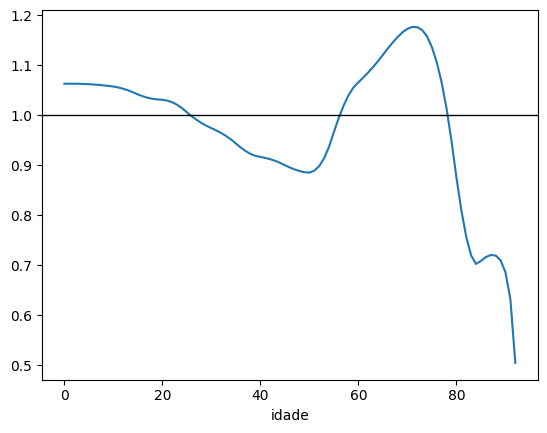

In [19]:
(final_df['n_homens'] / final_df['n_mulheres']).plot()
pl.axhline(1, color='k', linewidth=1)
pl.show()